# Resistivity fit for Heusler alloys

In case of magnetic alloys, the electrons are scattered mainly by three factors; the lattice defects or surface scattering ($\rho$) (a temperature independent effect), the lattice vibration ($\rho_{ph}$), and the magnonic scattering ($\rho_{mag}$) thus impeding the electron conduction. Hence, the total resistivity of a ferromagnetic alloy can be written as; $$ \rho(T) = \rho_0 + \rho_{ph}(T) + \rho_{mag}(T) \tag{1}$$

The temperature dependent electrical resistivity due to electron-phonon interaction can be modeled using Bloch-Gr$\ddot{u}$neisen formula; $$ \rho_{ph}(T) = \alpha (\frac{T}{\Theta_D})^5 \int_{0}^{\frac{\Theta_D}{T}} \frac{x^5}{(e^x - 1)(1 - e^{-x})}dx  \tag{2}$$
$\alpha$ is a constant that is proportional to $ \frac{\lambda_{tr}\omega_D}{\omega_p^2}$ ($\lambda_{tr}$ is electron-phonon coupling constant, $\omega_D$ is Debye frequency, and $\omega_p$ is plasma frequency) and $\Theta_D$ is Debye temperature.

The magnetic contribution is expected to follow a $T^2$ variation related to one magnon scattering. But, in case of half-metals, the spin flip-scattering is absent due to the existence of a gap in one of the spin channels. Hence, the electron-magnon scattering can be modified as; $$\rho_{mag}(T) = \beta T^2e^{-\frac{\Delta}{T}} \tag{3}$$
here $\Delta$ gives an estimated measure of energy gap between the Fermi level and the unoccupied band edge. The detailed information can be found in [[Link]](https://journals.aps.org/prmaterials/pdf/10.1103/PhysRevMaterials.3.114406).

In this notebook, we want to fit equation (1) incorporating the phonon and magnon scattering term from (2) and (3) such that the best value of parameters; $\Theta_D,\ \rho_0,\ \alpha,\ \beta,$ and $\Delta$ can be estimated. 

In [1]:
import numpy as np
from math import exp, pi
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
# define integral part of equation (2), i.e., Bloch-Gruneisen part
f = lambda x: np.power(x,5)/((exp(x)-1)*(1-exp(-x)))

n = 5

def resistivity_fit(T, *p):
    Theta_D, rho0, alpha, beta, delta = p
    coeff = np.power(T,n)/np.power(Theta_D, n)
    upp_limit = Theta_D/T
    res, err = quad(f, 0, upp_limit)
    rho = rho0 + alpha*coeff*res + beta*np.power(T,2)*exp(-(delta/T))  # equation (1)
    return 1.0/(1.0/rho)    

### Import data

The data should contain resistivity values in one column. If one is interested in knowing how to convert experimentally measured resistances (following Van der Pauw method), they can check out my other notebook [[Link]](https://github.com/skc46/Magnetic_material_science_research_related/blob/master/Van_der_Pauw_tofind_Sheet_resistance.ipynb).

In [48]:
import os
import pandas as pd
file_path = 'file_directory'
file_name = 'no_iterative_resistivity.xlsx'
file = os.path.join(file_path, file_name)
df = pd.read_excel(file)
df.head()

,Temp,Rho
0,3.99956,0.000038
1,9.01359,0.000038
2,14.02762,0.000038
3,19.04164,0.000038
4,24.05567,0.000038


In [22]:
# converting sheet resistance into resistivity, if the data already has resistivity, this step can be skipped
sample_thickness = 0.091  # in cm
df['Rho'] = df['Rs']*sample_thickness
df.head()

,Unnamed: 0,index,Temp,RA,RB,Rs,Rho
0,0,0,400.141177,0.000392,0.000175,0.001283,0.000117
1,1,2,398.116829,0.000396,0.000171,0.001286,0.000117
2,2,4,396.077686,0.000392,0.000170,0.001273,0.000116
3,3,6,394.070232,0.000389,0.000173,0.001273,0.000116
4,4,8,392.063474,0.000385,0.000173,0.001265,0.000115


In [77]:
exp_temp = df['Temp']
exp_rho = df['Rho']

p0 = np.array([300.0, 0.0001, 0.002,3e-7,3000])  # initial values of the parameters

# the functin has to to accept the entire T array
resistivity_wrapper = np.vectorize(resistivity_fit)

popt, pcov = curve_fit(resistivity_wrapper, exp_temp, exp_rho, p0)

print("Best fitted parameters; \u03F4_D :{} K \t \u03C1_0 :{} \u03A9-cm \t \u03B1 :{} \u03A9-cm \t \u03B2 :{} \u03A9-cm/K^2 \t \u0394 :{} K".format(popt[0],popt[1],popt[2],popt[3],popt[4]))


Best fitted parameters; ϴ_D :289.4790936573971 K 	 ρ_0 :3.824549412112625e-05 Ω-cm 	 α :0.007996632721963335 Ω-cm 	 β :1.3008405949158132e-09 Ω-cm/K^2 	 Δ :2627.395598803756 K


#### Visualizing the experimental and fitted curve

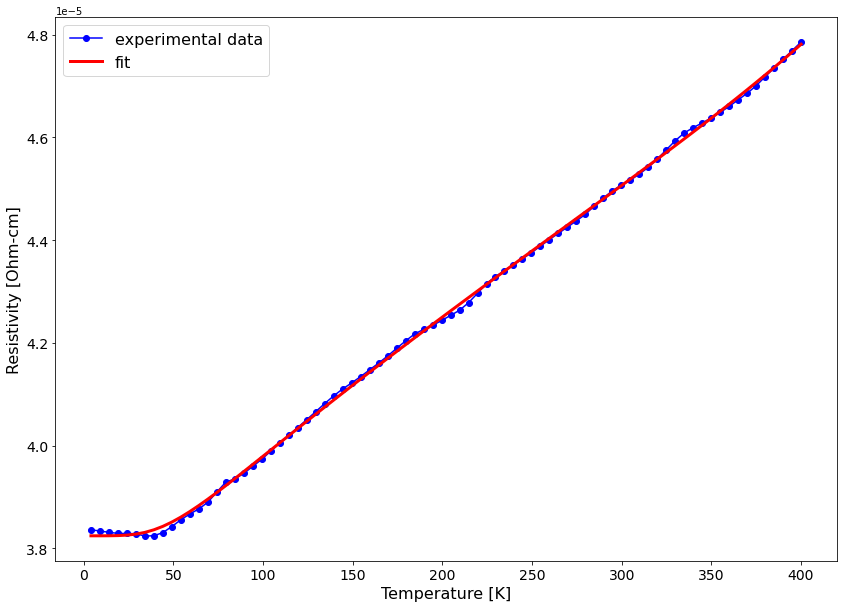

In [91]:
plt.figure(figsize=(14,10))
plt.plot(exp_temp, exp_rho, 'b-o', label='experimental data')
plt.plot(exp_temp, resistivity_wrapper(exp_temp, *popt), 'r-', label='fit', linewidth=3)
plt.xlabel('Temperature [K]', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Resistivity [Ohm-cm]', fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

One can get the error for best estimated parameters.

In [63]:
error=[]
for i in range(len(popt)):
    try:
        error.append(np.sqrt(pcov[i][i]))

    except:
        error.append(0.00)
print(error)  

[6.527278056922644, 2.042286084340276e-08, 0.000373164283229884, 3.318652642586509e-09, 1022.2917825393197]


The validity of the fit can be examined by plotting the residual. In general, no definite pattern should be observed in the residual plot (that is the plot should look random plot).

In [64]:
residual=[]
i=0
chi_square=0
while (i<len(temp_exp)):
    foo = resistivity_fit(exp_temp[i],*popt)
    residual.append((exp_rho[i]-foo)/exp_rho[i])
    chi_square += np.power(exp_rho[i]-foo,2)/foo
    i += 1
    
dof =  3.0 #4 parameters, so 3 degrees of freedom
chi_square = chi_square/dof

#print fity
print ('reduced chi square {0}'.format(chi_square))    

reduced chi square 1.9793691800030904e-09


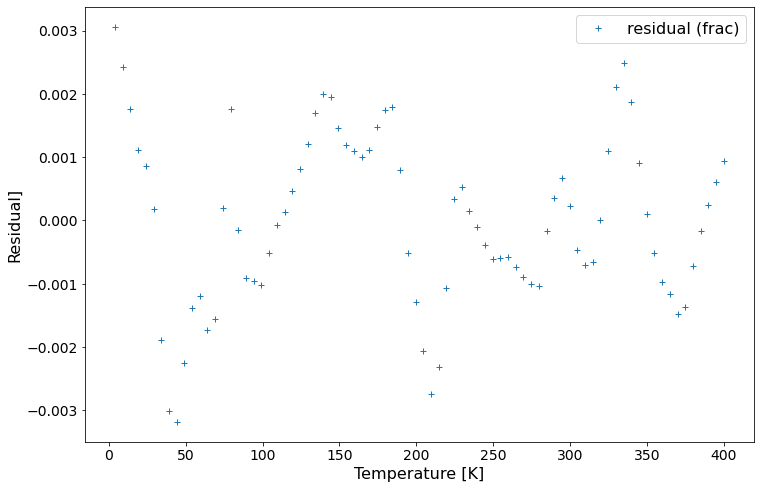

In [94]:
plt.figure(figsize=(12,8))
plt.plot(exp_temp,residual, '+', label='residual (frac)')
plt.xlabel('Temperature [K]', fontsize = 16)
plt.xticks(fontsize=14)
plt.ylabel('Residual]', fontsize=16)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=16)

One can create the fitted data and save it so that any other software can be used for plotting.

In [82]:
#construct the temperature data
temp = np.linspace(temp_exp.min(), temp_exp.max(), 100)

fitx=[]
fity=[]
resid=[]
i=0
while (i<80):
    fitx.append(temp[i])
    fity.append(resistivity_fit(temp[i],*popt))
    i += 1

# adding to the original dataframe
df['fitx'] = pd.Series(np.array(fitx))
df['fity'] = pd.Series(np.array(fity))
df['Residual']= pd.Series(np.array(residual))
outfile = os.path.join(file_path, file_name.strip('.xlsx'))  # remove the file type extension
df.to_csv(outfile+'fitted.csv', sep=',')